### Histograms in machine vision
- Represent the distribution of colours in an image.
- Can serve as feature vectors -> are images with similar histograms semantically similar?
- Measuring distance between histograms:
    - Euclidean
    - Correlation
    - Chi-squared
    - Intersection
    - Battacharyya

In [ ]:
# cv2.calcHist(images, channels, mask, histSize, ranges)
# images -> list of images to compute hists for
# list of channels we want to compute a histogram for
# mask -> Filter of our choice
# histSize -> Number of bins to use in histogram (one for each channel)
# ranges -> ranges of possible px values (e.g. [0, 256])

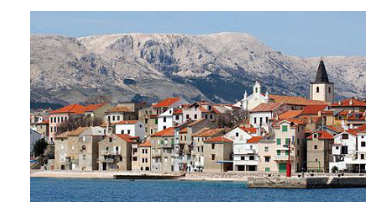

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
plt.style.use('bmh')

image = cv2.imread('./images/baske.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off');

In [61]:
hist = cv2.calcHist([image], [0], mask=None, histSize=[256],
                    ranges=[0, 256])

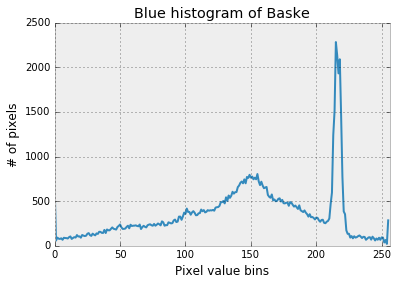

In [62]:
plt.plot(hist)
plt.xlim([0, 256])
plt.xlabel('Pixel value bins')
plt.ylabel('# of pixels')
plt.title('Blue histogram of Baske');

In [63]:
hist_g = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)],
                      [0], None, [256], [0, 256])

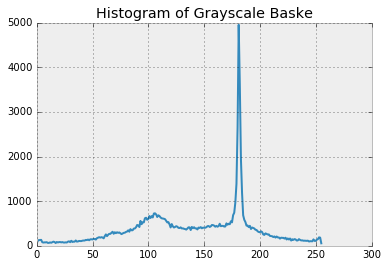

In [64]:
plt.plot(hist_g)
plt.title('Histogram of Grayscale Baske');

And for each of the channels in isolation?

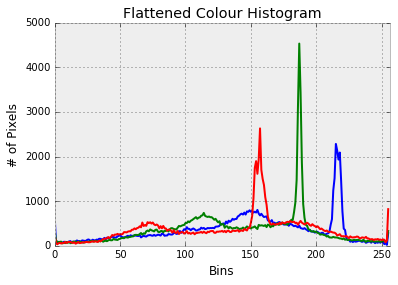

In [65]:
chans = cv2.split(image) # Splits image into 3 channels
c = ['b', 'g', 'r']
features = []

for color, chan in zip(c, chans):
    # Compute the histogram
    h = cv2.calcHist([chan], [0], None, [256], [0, 256])
    # Append the histogram to flattened histogram
    features.extend(hist)
    # Plot the histogram
    plt.plot(h, color=color)
    plt.xlim([0, 256])
plt.title('Flattened Colour Histogram')
plt.xlabel('Bins')
plt.ylabel('# of Pixels')

Next up - multidimensional histograms. These are joint distributions for different channels' values.

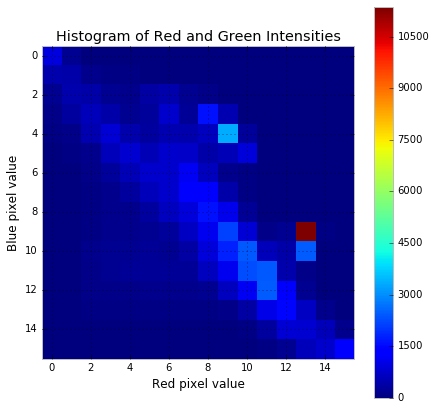

In [76]:
plt.figure(figsize=(7, 7))
hist = cv2.calcHist([chans[2], chans[0]], [0, 1], None, [16, 16],
                    [0, 256, 0, 256])
p = plt.imshow(hist, interpolation='nearest')
plt.colorbar(p)
plt.title('Histogram of Red and Green Intensities')
plt.xlabel('Red pixel value');
plt.ylabel('Blue pixel value');

Practical note: when summarizing clusters of pixels using 2D (or histograms